In [73]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import format_number, mean, min, max, corr
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format)
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

In [74]:
 # Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [75]:
papers_ = spark.read.option("multiLine", True).option("mode", "PERMISSIVE").option("encoding", "ascii").json("./Finaldata.json")
papers = papers_.select(explode(col("hits.hits")).alias("paper"))

In [77]:
papers.count()

250

In [78]:
 def ascii_ignore(x):
    return x.encode('ascii', 'ignore').decode('ascii')
ascii_udf = udf(ascii_ignore)

In [79]:
short_papers = papers.select(
    element_at(col("paper.metadata.titles.title"), 1).alias("title"),
    element_at(col("paper.metadata.abstracts.value"), 1).alias("abstract"),
    col("paper.created"), col("paper.metadata.number_of_pages"),
    col("paper.metadata.keywords"), size(
        col("paper.metadata.references")).alias("num_refs"),
    col("paper.metadata.authors.full_name").alias("authors")
).withColumn("title", ascii_udf("title"));
short_papers.printSchema()

root
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- created: string (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- schema: string (nullable = true)
 |    |    |-- source: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- num_refs: integer (nullable = false)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [80]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [81]:
kws  = short_papers.select(explode(col("keywords"))).select("col.value").withColumnRenamed("value", "K")
kws.groupby("K").count().sort(desc("count")).show(truncate=False)

+-------------------------------------------+-----+
|K                                          |count|
+-------------------------------------------+-----+
|CERN LHC Coll                              |30   |
|new physics                                |24   |
|GeV                                        |17   |
|quantum chromodynamics                     |16   |
|structure                                  |16   |
|effective field theory                     |15   |
|quark                                      |13   |
|thermal                                    |12   |
|lattice                                    |12   |
|sensitivity                                |12   |
|critical phenomena                         |12   |
|numerical calculations                     |12   |
|cosmological model                         |12   |
|TeV                                        |11   |
|lattice field theory                       |11   |
|kinematics                                 |11   |
|p p: scatte

In [91]:
key_p = short_papers.select(explode(col("keywords"))).select("col.value")

In [92]:
key_p.printSchema()

root
 |-- value: string (nullable = true)



In [93]:
pandasDF = key_p.toPandas()
print(pandasDF)

                                           value
0     Particle Physics Beyond the Standard Model
1                      Extra Dimensions of Space
2                                         Branes
3                         Non-local Field Theory
4                                    Naturalness
...                                          ...
2922                                 accelerator
2923                                     IceCube
2924                                    magnetar
2925                                         TeV
2926                                       burst

[2927 rows x 1 columns]


In [94]:
len(single)

187361

In [96]:
!pip install wordcloud

In [104]:
import re 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [110]:
text = []
for i in pandasDF['value']: 
    r = str(i)
    r = re.sub(r'[^\w]', ' ', r)
    text.append(r)

In [111]:
single = ' '.join(text)

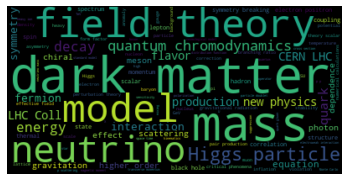

In [112]:
wordcloud = WordCloud().generate(single)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()